In [1]:
cd /content/drive/My Drive/Colab Notebooks/new_sateliteImage

/content/drive/My Drive/Colab Notebooks/new_sateliteImage


In [2]:
ls

'archive (3).zip'            dataset.py                     runs/
 checkpoint/                 engine.py                      split_data.py
 checkpoint_ssd300.pth.tar   engine.pyc                     test_data_images/
 chkpoint_                   evaluate.py                    train.py
 coco_eval.py                inference.ipynb                transforms.py
 coco_utils.py               Oct21_04-00-41_dfff1a48e47f/   transforms.pyc
 coco_utils.pyc              predict.py                     utils.py
 data/                       __pycache__/


In [3]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import os
import cv2
import random
import argparse

In [4]:
imgs = os.listdir('test_data_images/test_data_images/images/')
len(imgs)

2703

In [5]:
from train import build_model, get_transform
from dataset import SatelliteDataset
import transforms as T
import utils
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import Tensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb

dataset_test = SatelliteDataset('test_data_images/test_data_images/images/', get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)
# pdb.set_trace()
#Load model 
model = build_model(3)
rand_img = random.sample(imgs, 10) 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint = torch.load("./checkpoint/chkpoint_9.pt", map_location={'cuda:0': 'cpu'}) #read from last checkpoint
model.load_state_dict(checkpoint['state_dict'])
model.eval() #evaluation mode
# pdb.set_trace()
# img_path = os.path.join(os.getcwd(), "test_data_images/test_data_images/images", rand_img[0])
img_path = os.path.join(os.getcwd(), "test_data_images/test_data_images/images", "000000001.jpg")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [15]:
CLASS_NAMES = ["__background__", "car","pool"]
def get_prediction(model, img_path, threshold):
  img = Image.open(img_path) # Load the image
  my_transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
  img = my_transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  # pdb.set_trace()
  pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  # print(len(pred_boxes))
  # print(pred)
  return pred_boxes, pred_class

def object_detection_api(img_path, model, threshold=0.5, rect_th=1, text_size=3, text_th=3):

  boxes, pred_cls = get_prediction(model, img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=1) # Write the prediction class
  # plt.figure(figsize=(20,30)) # display the output image
  plt.figure(figsize=(8,8))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  # Show subplots | shape: (1,3) 
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
  for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(a**(i+1), cmap=plt.cm.jet)
      #plt.colorbar()
      plt.title('Image: {}'.format(i+1))

  #plt.tight_layout()
  plt.suptitle('Overall Title')
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(lum_img)
  ax.set_title('Before')
  plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(lum_img)
  imgplot.set_clim(0.0, 0.7)
  ax.set_title('After')
  plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

# print(get_prediction(model, img_path, 0.5))


In [21]:
def object_detection_api(img_path, model, threshold=0.5, rect_th=1, text_size=3, text_th=3):

  fig = plt.figure(figsize=(16,16))
  ax = fig.add_subplot(1, 2, 1)
  boxes, pred_cls = get_prediction(model, img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  plt.imshow(img)
  ax = fig.add_subplot(1, 2, 2)
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=1) # Write the prediction class
  # plt.figure(figsize=(20,30)) # display the output image
  # plt.figure(figsize=(8,8))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  # # Show subplots | shape: (1,3) 
  # fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
  # for i, ax in enumerate(axs.flatten()):
  #     plt.sca(ax)
  #     plt.imshow(a**(i+1), cmap=plt.cm.jet)
  #     #plt.colorbar()
  #     plt.title('Image: {}'.format(i+1))

  # #plt.tight_layout()
  # plt.suptitle('Overall Title')
  # plt.show()

  # fig = plt.figure()
  # ax = fig.add_subplot(1, 2, 1)
  # imgplot = plt.imshow(lum_img)
  # ax.set_title('Before')
  # plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
  # ax = fig.add_subplot(1, 2, 2)
  # imgplot = plt.imshow(lum_img)
  # imgplot.set_clim(0.0, 0.7)
  # ax.set_title('After')
  # plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')


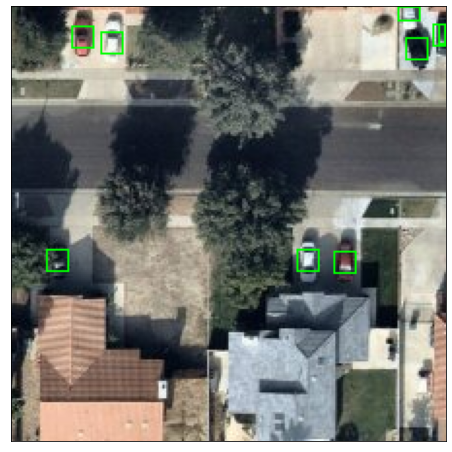

In [16]:
img_path = os.path.join(os.getcwd(), "test_data_images/test_data_images/images", "000000006.jpg")
object_detection_api(img_path, model)

In [22]:
for img_name in rand_img:
  img_path = os.path.join(os.getcwd(), "test_data_images/test_data_images/images", img_name)
  object_detection_api(img_path, model)


Output hidden; open in https://colab.research.google.com to view.

000002503.jpg
(<PIL.Image.Image image mode=RGB size=224x224 at 0x7F3E1F851400>, {'boxes': tensor([[ 17.0100,  28.5600,  28.1200,  39.6700],
        [177.0300,   0.6300, 188.1400,  11.7400],
        [185.1700,  13.3700, 196.2900,  24.4900],
        [113.2700, 213.5700, 124.3800, 224.0000],
        [113.9900, 189.7600, 125.1100, 200.8700]]), 'labels': tensor([1, 1, 1, 1, 1]), 'image_id': tensor([2]), 'area': tensor([123.4321, 123.4321, 123.6543, 115.8772, 123.5432]), 'iscrowd': tensor([0, 0, 0, 0, 0])})
tensor([[ 17.0100,  28.5600,  28.1200,  39.6700],
        [177.0300,   0.6300, 188.1400,  11.7400],
        [185.1700,  13.3700, 196.2900,  24.4900],
        [113.2700, 213.5700, 124.3800, 224.0000],
        [113.9900, 189.7600, 125.1100, 200.8700]])


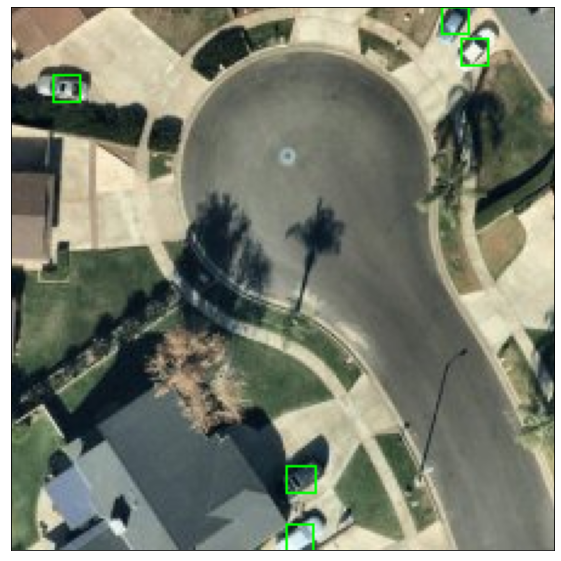

In [8]:
from dataset import SatelliteDataset
a= SatelliteDataset('data/training_data/images')
idx = 2
print(a.lst_images[idx])
print(a.__getitem__(idx))
res = a.__getitem__(idx)
img_path = 'data/training_data/images/' + a.lst_images[idx]
img = cv2.imread(img_path) # Read image with cv2
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
_, img_info = a.__getitem__(idx)
boxes = img_info['boxes']
print(boxes)
boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(boxes.detach().numpy())]
boxes
for i in range(len(boxes)):
  cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=1) # Draw Rectangle with the coordinates
  # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=1) # Write the prediction class
# plt.figure(figsize=(20,30)) # display the output image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()